In [2]:
import requests

# From https://stackoverflow.com/a/39225272
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = __get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    __save_response_content(response, destination)    

def __get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def __save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)




In [3]:
import pandas as pd

# File ID is just the part of the link after /d/ and before ? URL parameters
file_id = "13zaHkIT1PD_YDu3tjJj1eZv-WGzooZ6r"
destination = '2023-04-15_beanstack.csv'

import os
if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [4]:
import pandas as pd
ork_csv = pd.read_csv("~/Downloads/beanbooster-sim.csv", comment="#")
csv = pd.read_csv(destination)

In [5]:

FT_TO_M = 0.3048
G_ACCEL_EARTH = 9.80655
LAPSE_RATE = -6.5e-3
R_DRY_AIR = 287.053
G_ACCEL_EARTH = 9.80665
GROUND_TEMP = 20 + 273.15
PRESSURE_REF = 0.993872440167777

def pressure_to_alt(pressureAtm, tempRefK, pressureRefAtm, agl: bool = True):
    ret = ((tempRefK) / LAPSE_RATE) * (pow(pressureAtm / pressureRefAtm, -R_DRY_AIR * LAPSE_RATE / G_ACCEL_EARTH) - 1)
    if agl:
        ret = ret - ret.iloc[0]
    return ret


[[ 0.          0.        ]
 [ 0.09191961  1.04339038]
 [ 0.30028015  2.08941446]
 ...
 [ 1.18621544 -0.5489984 ]
 [ 1.17039546 -0.54810626]
 [ 1.17198126 -0.52671256]]


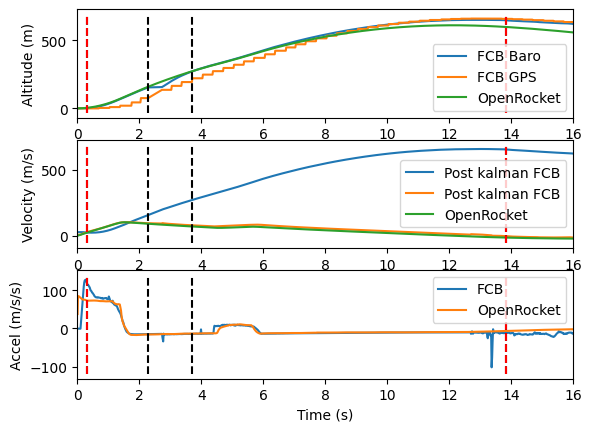

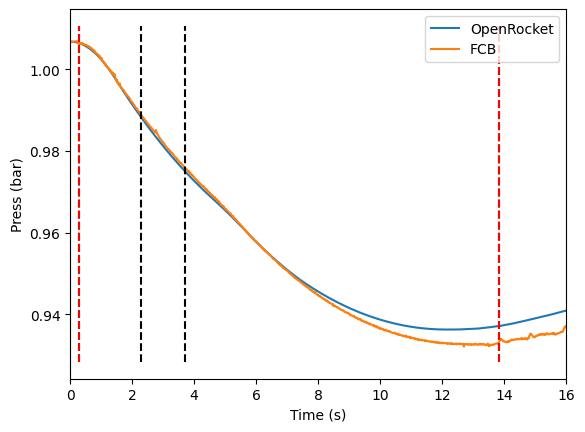

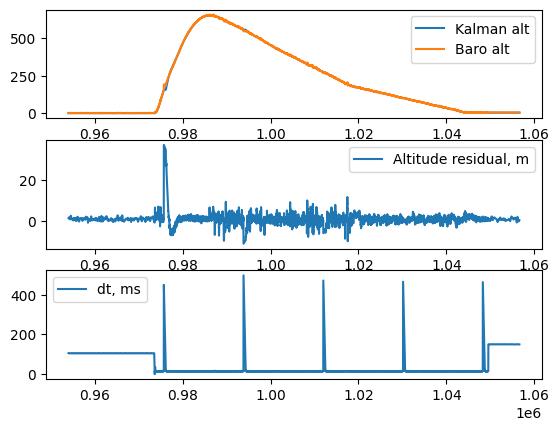

In [8]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

# import matplotlib
# matplotlib.use('nbagg')

import matplotlib.pyplot as plt
import numpy as np

def rerun_kalman(csv):
    import numpy as np
    x_hat = np.array([0.0, 0.0]).reshape((2, 1))
    K_steady = np.array([0.03407042, 0.03685564]).reshape((2, 1))
    last_time_ms = csv["timestamp_s"].iloc[0]
    out = []
    for idx, row in csv.iterrows():
        if row["state"] == 3:
            u = 0.0
        else:
            u = row["imu1_accel_y_real"]

        dt = row["timestamp_s"] - last_time_ms
        last_time_ms = row["timestamp_s"]

        # predict
        x_hat[0,0] += x_hat[1,0] * dt + 0.5 * u * dt * dt
        x_hat[1,0] += u * dt

        # correct
        error = row["baro_alt_avg"] - x_hat[0, 0]
        x_hat[0,0] += K_steady[0,0] * error
        x_hat[1,0] += K_steady[1,0] * error

        # print(f"dt {dt} u {u} pos {x_hat[0,0]} vel {x_hat[1,0]} error {error}")

        out.append(x_hat.T.copy())
    out = np.array(out)
    return out

# Add some extra post process data
csv['timestamp_s'] = csv['timestamp_ms'] / 1000
pressure_array = csv["baro_pres_avg"]
baro_alt = pressure_to_alt(pressure_array, GROUND_TEMP, PRESSURE_REF)
csv["baro_alt_avg"] = baro_alt


transitions = np.where(csv.state[:-1].values != csv.state[1:].values)[0]
vlines = [csv["timestamp_ms"][index] / 1000 for index in transitions]
ascent = vlines[0]
flight_offset = ascent - 0.3

fcb_time = csv["timestamp_ms"] / 1000 - flight_offset

triggerChanges = np.where(csv.trigger_status[:-1].values != csv.trigger_status[1:].values)[0]
triggerVlines = [csv["timestamp_ms"][index] / 1000 for index in triggerChanges]

X_MIN = 0
X_MAX = 16



def add_trigger_lines():
    yMin, yMax = plt.ylim()
    plt.vlines(x=triggerVlines - flight_offset, ymin=yMin, ymax=yMax,ls="--", colors="black")
    plt.vlines(x=vlines - flight_offset, ymin=yMin, ymax=yMax,ls="--", colors="red")


plt.figure()
# Alt vs time
plt.subplot(311)
plt.plot(fcb_time, csv["pos_z"], label="FCB Baro")
plt.plot(fcb_time, csv["gps_alt"] - csv["gps_alt"][0], label="FCB GPS")
plt.plot(ork_csv["Time (s)"], ork_csv["Altitude (ft)"] * FT_TO_M, label="OpenRocket")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.xlim((X_MIN, X_MAX))
add_trigger_lines()

# Vel vs time
plt.subplot(312)
# plt.plot(fcb_time, csv["vel_z"], label="FCB (Kalman)")

xhat = rerun_kalman(csv)
plt.plot(fcb_time, xhat[:,0], label="Post kalman FCB")
print(xhat[:,0])

plt.plot(ork_csv["Time (s)"], ork_csv["Vertical velocity (ft/s)"] * FT_TO_M, label="OpenRocket")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.xlim((X_MIN, X_MAX))
add_trigger_lines()

# Accel vs time
plt.subplot(313)
plt.plot(fcb_time, csv["acc_z"] - G_ACCEL_EARTH, label="FCB")
plt.plot(ork_csv['Time (s)'], ork_csv['Vertical acceleration (G)'] * G_ACCEL_EARTH, label="OpenRocket")

plt.xlabel("Time (s)")
plt.ylabel("Accel (m/s/s)")
# plt.ylim((-20, 35))
plt.legend()
plt.xlim((X_MIN, X_MAX))
add_trigger_lines()


# ==== pressure graph ====

plt.figure()
ATM_TO_BAR = 1.01325
plt.plot(ork_csv["Time (s)"], ork_csv["Air pressure (mbar)"] / 1000, label="OpenRocket")
plt.plot(fcb_time, csv["baro_pres_avg"] * ATM_TO_BAR, label="FCB")
plt.xlabel("Time (s)")
plt.ylabel("Press (bar)")
plt.legend()
plt.xlim((X_MIN, X_MAX))
add_trigger_lines()

def plot_altitude_residual():
    # Drop the first baro alt
    pressure_array = csv["baro_pres_avg"]
    baro_alt = pressure_to_alt(pressure_array, GROUND_TEMP, PRESSURE_REF)
    baro_alt2 = baro_alt.iloc[1:]

    pos_z2 = csv["pos_z"].iloc[:-1]

    time = csv["timestamp_ms"].iloc[:-1]

    plt.figure()
    plt.subplot(311)
    plt.plot(time, pos_z2, label="Kalman alt")
    plt.plot(time, baro_alt2, label="Baro alt")
    plt.legend()
    plt.subplot(312)
    plt.plot(time, baro_alt2.to_numpy() - pos_z2.to_numpy(), label="Altitude residual, m")
    # plt.plot(csv['timestamp_ms'], csv2["vel_z"], label="Z vel, m/s")
    plt.legend()
    plt.subplot(313)
    # plt.plot(csv2["timestamp_ms"], csv2['acc_z'], label="Accel Z")
    # plt.plot(csv["timestamp_ms"], csv['trigger_status'], label="Big Trig")
    plt.plot(time, np.diff(csv["timestamp_ms"]), label="dt, ms")
    plt.legend()

    # plt.figure()
    # plt.plot(time, np.diff(csv["timestamp_ms"]) * 1000, label="dt, ms")
    # plt.scatter(csv["timestamp_ms"], csv["timestamp_ms"] * 1000, label="dt, ms")
    # print(max(np.diff(csv["timestamp_ms"]) * 1000))
    # plt.legend()

plot_altitude_residual()

plt.show()

